# <a>Classificação de Imagens - PyTorch e Transfer Learning</a>



## <a> Objeto de Estudo </a>

A rede de supermercados fictícia, Let's Veggie, precisa de um produto mínimo viável que possa ser testado nas filiais da empresa. O problema a ser solucionado é a dificuldade em classificar os produtos das lojas. Muitos funcionários não sabem diferenciar os vegetais e frutas e uma aplicação que faça essa classificação pode ajudar bastante na expansão da companhia.

Será efetuada uma classificação de batatas, cenouras, tomates e limões, para prova de conceito.

![Let's Veggie](images/letsveggie.png)


### <a>Criação e separação de bases</a>

Com as imagens baixadas do google images pode-se separá-las em treino, validação e teste.

O projeto requer somente uma pasta "raw" dentro de "data" com uma pasta para cada classe a ser treinada.

Ex: ./data/raw/cenoura/imagem1.jpg

In [1]:
#!pip install torch torchvision pillow scikit-learn gradio

In [2]:
# Importar as bibliotecas necessárias: destaque para pytorch

from matplotlib import pyplot as plt
import numpy as np
import os
import PIL.Image

import time
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [3]:
# Primeiro vamos separar as imagens em base de treino, validação e teste
# É interessante deixar uma pasta raw com os dados originais para o caso
# de fazermos alguma "caquinha"

diretorio_base_imagens = './data/raw'
pastas_com_nomes_de_vegetais = os.listdir('./data/raw')
pastas_com_nomes_de_vegetais


['batata', 'cenoura', 'limao', 'tomate']

In [4]:
# Verificando quantas imagens tem em cada pasta
len(os.listdir(os.path.join(diretorio_base_imagens, 'cenoura')))

181

In [5]:
# Vamos criar uma separação estratificada

quantidade_por_label = {pasta: len(os.listdir(os.path.join(diretorio_base_imagens, pasta))) for pasta in pastas_com_nomes_de_vegetais}

quantidade_por_label

{'batata': 146, 'cenoura': 181, 'limao': 111, 'tomate': 107}

In [6]:
# Criando as pastas de treino, validação e testes

diretorio_imagens_processadas = './data/processed/'

dir_treino = os.path.join(diretorio_imagens_processadas, 'treino')
dir_validacao = os.path.join(diretorio_imagens_processadas, 'validacao')
dir_teste = os.path.join(diretorio_imagens_processadas, 'teste')

if not os.path.exists(dir_treino):
    os.makedirs(dir_treino)

if not os.path.exists(dir_validacao):    
    os.makedirs(dir_validacao)

if not os.path.exists(dir_teste):
    os.makedirs(dir_teste)

In [7]:
pastas_com_nomes_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [8]:
dir_treino, dir_validacao, dir_teste

('./data/processed/treino',
 './data/processed/validacao',
 './data/processed/teste')

In [9]:
diretorio_base_imagens

'./data/raw'

In [10]:
import shutil
from sklearn.model_selection import train_test_split

# Criando uma pasta para cada classe (batata, cenoura, limao, tomate)
# dentro de treino, validação e teste

for classe in pastas_com_nomes_de_vegetais:
    # os.path.join cria paths com os separadores corretos pra cada sistema operacional
    # barra normal, barra invertida, isso muda do Windows pro Linux/Mac
    dir_classe_treino = os.path.join(dir_treino, classe)
    dir_classe_validacao = os.path.join(dir_validacao, classe)
    dir_classe_teste = os.path.join(dir_teste, classe)
    
    # Efetivamente criando as pastas de treino, validação e teste
    # Testa primeiro se as pastas já não existem
    if not os.path.exists(dir_classe_treino):
        os.makedirs(dir_classe_treino)

    if not os.path.exists(dir_classe_validacao):
        os.makedirs(dir_classe_validacao)
    
    if not os.path.exists(dir_classe_teste):
        os.makedirs(dir_classe_teste)
    
    # caminho completo para a pasta com imagens originais
    pasta_classe = os.path.join(diretorio_base_imagens, classe)
    
    # listando todos os arquivos de imagem para essa classe
    arquivos_classe = os.listdir(pasta_classe)
    
    # separando 80% para treino e 20% para validação+teste
    treino, valid_teste = train_test_split(arquivos_classe, 
                                           shuffle=True, 
                                           test_size=0.2, 
                                           random_state=42)
    
    # separando os 20% da validação+teste em 10% para validação e 10% para teste
    validacao, teste = train_test_split(valid_teste, shuffle=True, test_size=0.5, random_state=42)
    
    # Não precisamos mais dessa lista temporária
    del valid_teste
    
    print(f'{classe} - treino: {len(treino)} - valid: {len(validacao)} - teste: {len(teste)} - total: {len(arquivos_classe)}')
    
    # Copiando os arquivos efetivamente para as pastas de treino, validação e teste
    for imagem_treino in treino:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_treino)
        caminho_destino = os.path.join(dir_classe_treino, imagem_treino)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_validacao in validacao:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_validacao)
        caminho_destino = os.path.join(dir_classe_validacao, imagem_validacao)

        shutil.copy(caminho_origem, caminho_destino)

    for imagem_teste in teste:
        caminho_origem = os.path.join(diretorio_base_imagens, classe, imagem_teste)
        caminho_destino = os.path.join(dir_classe_teste, imagem_teste)

        shutil.copy(caminho_origem, caminho_destino)        
        
        
        
        
    

batata - treino: 116 - valid: 15 - teste: 15 - total: 146
cenoura - treino: 144 - valid: 18 - teste: 19 - total: 181
limao - treino: 88 - valid: 11 - teste: 12 - total: 111
tomate - treino: 85 - valid: 11 - teste: 11 - total: 107


### <a>Pré processamento</a>

Início do processamento das imagens para utilizar no modelo do PyTorch.

Criação das transformações para redimensaionar as imagens e transformá-las em tensores PyTorch.

In [11]:
# Setando o tamanho da imagem
image_size = 100

# Transformando as imagens: para modelos mais robustos tem que caprichar no data augmentation!
# Nesse caso não fizemos nada além do redimensionamento da imagem, mas é sempre bom fazer rotações,
# espelhamentos, crop randomicos pra garantir 
transformacoes_de_imagens = { 
    'treino': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ]),
    'teste': transforms.Compose([
        transforms.Resize(size=[image_size, image_size]),
        transforms.ToTensor(),
    ])
}

In [12]:
# Carregar as imagens
# Determinar as pastas de treino, validação e teste

pasta_treino = dir_treino
pasta_validacao = dir_validacao
pasta_teste = dir_teste

pasta_treino, pasta_validacao, pasta_teste

('./data/processed/treino',
 './data/processed/validacao',
 './data/processed/teste')

#### <a>Preparação para o treinamento</a>

Vamos definir informações importantes para o treinamento do modelo. Tamanho do batch, número de classes, datasets, data loaders, otimizadores.

In [13]:
# Tamanho do batch de treinamento
tamanho_do_batch = 8

# Determinando o número de classes (verduras/frutas)
numero_de_classes = len(os.listdir(pasta_treino))

numero_de_classes

4

In [14]:
pasta_treino

'./data/processed/treino'

In [15]:
# Carregar as imagens usando o datasets do torchvision
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [16]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 433
     Root location: ./data/processed/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 55
     Root location: ./data/processed/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[100, 100], interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            )}

In [17]:
# Mapear os índices com os nomes das classes (cada índice vai ter um nome de hortifruti relacionado)
indice_para_classe = {indice: classe for classe, indice in data['treino'].class_to_idx.items()}

indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [18]:
# Quantidade de imagens para serem utilizados para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

num_imagens_treino, num_imagens_validacao

(433, 55)

In [19]:
# Cria os DataLoaders para treino e validação
# O DataLoader organiza os dados de treinamento e validação para o treinamento da rede neural
data_loader_treino = DataLoader(data['treino'], batch_size=tamanho_do_batch, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=tamanho_do_batch, shuffle=True)

In [20]:
data_loader_treino, data_loader_validacao

(<torch.utils.data.dataloader.DataLoader at 0x203903f5910>,
 <torch.utils.data.dataloader.DataLoader at 0x2039b0c1d30>)

#### <a>Checar algumas imagens</a>

Vamos visualizar algumas imagens da base de treino para cada uma das classes.

In [21]:
indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

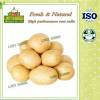

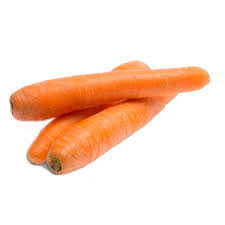

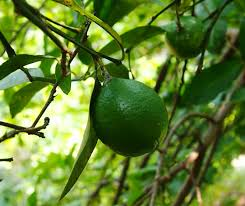

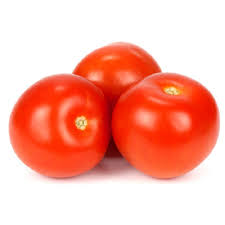

In [22]:
from IPython.display import Image 

# Mostrar algumas imagens
for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

#### <a>Transfer Learning</a>

Será utlizada uma rede já pré-treinada, pois é difícil obter um modelo bom com poucas imagens, como apresentado nesse projeto. 

A Alexnet é famosa por ter ganhado o prêmio de melhor classificador do banco Imagenet.

In [23]:
# Vamos carregar nossa linda e maravilhosa Alexnet, prontinha com milhões de imagens
# treinadas
alexnet = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')

# Dar uma "cheirada" e analisada na estrutura da rede Alexnet
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
type(alexnet)

torchvision.models.alexnet.AlexNet

In [25]:
for param in alexnet.parameters():
    print(param)

Parameter containing:
tensor([[[[ 1.1864e-01,  9.4069e-02,  9.5435e-02,  ...,  5.5822e-02,
            2.1575e-02,  4.9963e-02],
          [ 7.4882e-02,  3.8940e-02,  5.2979e-02,  ...,  2.5709e-02,
           -1.1299e-02,  4.1590e-03],
          [ 7.5425e-02,  3.8779e-02,  5.4930e-02,  ...,  4.3596e-02,
            1.0225e-02,  1.3251e-02],
          ...,
          [ 9.3155e-02,  1.0374e-01,  6.7547e-02,  ..., -2.0277e-01,
           -1.2839e-01, -1.1220e-01],
          [ 4.3544e-02,  6.4916e-02,  3.6164e-02,  ..., -2.0248e-01,
           -1.1376e-01, -1.0719e-01],
          [ 4.7369e-02,  6.2543e-02,  2.4758e-02,  ..., -1.1844e-01,
           -9.5567e-02, -8.3890e-02]],

         [[-7.2634e-02, -5.7996e-02, -8.0661e-02,  ..., -6.0304e-04,
           -2.5309e-02,  2.5471e-02],
          [-6.9042e-02, -6.7562e-02, -7.6367e-02,  ..., -3.9616e-03,
           -3.0402e-02,  1.0477e-02],
          [-9.9517e-02, -8.5592e-02, -1.0521e-01,  ..., -2.6587e-02,
           -2.2777e-02,  6.6451e-03]

In [26]:
# Congelar os parametros da rede pré-treinada
# Lembrando que o required_grad = False desliga o treinamento e atualização
# dos pesos (coeficientes) das camadas da rede neural
for param in alexnet.parameters():
    param.requires_grad = False

In [27]:
alexnet.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [28]:
# Mudar a última camada para alterar o número de classes
# Lembrando que aproveitamos a rede inteira, só plugamos uma camada final
# que efetivamente vai aprender as nossas classes (hortifruti)

# Alterando de Linear(in_features=4096, out_features=1000, bias=True)
# para Linear(in_features=4096, out_features=4, bias=True), pois temos 4 hortifruti
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)

# Incluindo softmax, que faz com que as probabilidades de ser cenoura, batata,
# limão ou tomate seja 1 (converte efetivamente em probabilidades para facilitar nossa análise)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))

alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
alexnet.classifier[6]

Linear(in_features=4096, out_features=4, bias=True)

In [30]:
# Perceba que a última camada é criada já com requires_grad = True
# ou seja, queremos efetivamente que ela seja treinada
parametros_ultima_camada = alexnet.classifier[6].parameters()

[parametro for parametro in parametros_ultima_camada][0].requires_grad

True

In [31]:
# Vamos utilizar a função de erro de entropia cruzada
# bastante comum para problemas de classificação
funcao_erro = nn.CrossEntropyLoss()

#### <a>Otimizador</a>

O Otimizador é quem efetivamente muda os pesos da rede de acordo com algum algoritmo

Nesse caso vamos utilizar o Adam Optimizer, mas poderíamos utilizar o Stochastic Gradient Descent, por exemplo

In [32]:
# perceba que passamos os parâmetros da rede para o otimizador poder alterá-los
otimizador = optim.Adam(alexnet.parameters())
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

#### <a>Treinar e Validar</a>

O treinamento realiza vários caminhos para frente (forward: previsão), cálculos de erro (distância entre previsão e valor real) e backward (backpropagation: aprendizado com o erro). A cada época, todas as imagens do treino são utilizadas para otimizar os parâmetros da rede. Dentro de cada época, utilizamos o treinamento em batch, ao invés de realizar o treinamento imagem por imagem.

Na validação, lembrar que não queremos manter o cálculo de gradientes, pois não vamos realizar o backpropagation.

In [33]:
def treinar_e_validar(modelo, metrica_erro, otimizador, epocas=10):
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador: otimizador para alterar os parâmetros da rede
        :param epocas: número de épocas (default=10)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    # inicializando historico
    # a melhor acuracia de validação
    # melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None
    
    # Opção para quem preferir utilizar uma placa de vídeo para execução
    # Caso não possua, a CPU será suficiente
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    print(device)
    
    # Cada época perpassa todas as imagens do treino e calcula erros de treino e validação
    # para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acertos_treino = 0.0
        
        # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acertos_validacao = 0.0
        
        # Itera a cada lote de imagem. As entradas são os tensores do lote (batch)
        # e o label são as classificações de cada imagem do lote: 
        # batata, cenoura, limão e tomate (0, 1, 2 e 3)
        for i, (imagens_lote, y_reais) in enumerate(data_loader_treino):
            print(f"\nLote: {i+1}\n")
            
            # joga pra GPU ou CPU, dependendo do seu hardware e pytorch instalado
            imagens_lote = imagens_lote.to(device)
            y_reais = y_reais.to(device)
            
            # Limpar os gradientes: zerar os gradientes
            otimizador.zero_grad()

            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            # Como o lote tem 8 imagens, teremos 8 previsões
            previsoes = modelo(imagens_lote)


            '''
            # Vamos entender melhor o que está se passando!
            print(imagens_lote.size()) # temos um tensor com 8 imagens
            print(previsoes) # temos tensor com 8 previsoes, cada um com 4 valores de log probabilidade
            print(torch.exp(previsoes)) # convertendo para exponencial para termos probabilidades de verdade
           
            print(torch.max(previsoes.data, 1))
           
            # Dando uma olhada nos y_reais
            print(y_reais)


            # Vamos dar uma olhadinha nas imagens do batch!
            for indice in range(tamanho_do_batch):
                tensor_para_imagem = transforms.ToPILImage()
                imagem = tensor_para_imagem(imagens_lote[indice])
                display(imagem)

            break
            '''
                
            # Calcular erro das saidas que foram preditas no forward pass
            # comparando com as classificacoes reais (predito vs real)
            # e retorna a média dos erros (são 8 erros)
            erro = metrica_erro(previsoes, y_reais)
           
            # O backpropagation é a junção do erro.backward() + otimizador.step()
            # erro.backward() calcula os gradientes, ou seja, qual a direção 
            # dos coeficientes para reduzir o erro
            # otimizador.step() atualiza os coeficientes de acordo com os gradientes
            # calculados no passo anterior
            
            # Realizar o cálculo dos gradientes a partir do erro de predição
            # O otimizador vai utilizar esses gradientes para saber
            # qual a direção deve atualizar os coeficientes da rede
            erro.backward()
            
            # Atualizar os parâmetros da rede de acordo com os gradientes calculados no backward
            otimizador.step()
            
            # Daqui pra frente são os cálculos de acurácia
            # para avaliar a evolução do modelo durante o treinamento
            # nas épocas
            
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            # O erro calculado já é a média dos 8 erros, portanto temos que multiplicar
            # pela quantidade de imagens do lote
            erro_treino += erro.item() * imagens_lote.size(0)
            
            # Cálculo da acurácia
            # Pra calcular a acurácia temos que buscar as classes preditas para cada imagem no lote
            
            # Cada tensor é uma imagem do lote com três posições: probabilidades de cada classe
            # torch.max vai retornar o valor da maior probabilidade, 
            # bem como a posição no tensor (tupla de saída)
            # A posição, portanto, vai indicar a classe com maior probabilidade (0,1,2 e 3)
            # 1o busca o valor máximo de cada tensor de cada imagem, que vai dar 
            # a classe final predita
            _, classes_previstas = torch.max(previsoes.data, 1)
            predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)
            
            # Converter os acertos para float e calcular a acurácia média
            # do lote
            acertos = torch.mean(predicoes_corretas)
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em train_acc
            acertos_treino += torch.sum(predicoes_corretas)
            
            #print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        # "desliga" o autograd
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (imagens_lote, y_reais) in enumerate(data_loader_validacao):
                imagens_lote = imagens_lote.to(device)
                y_reais = y_reais.to(device)

                # Forward pass de validação
                # Previsão do modelo treinado nessa época
                previsoes = modelo(imagens_lote)

                # Calcular erro de validação
                # Previsto versus os verdadeiros hortifruti
                erro = metrica_erro(previsoes, y_reais)

                # Calcular erro de validação e adicionar a valid_loss
                erro_validacao += erro.item() * imagens_lote.size(0)

                # Calcular a acurácia de validação
                _, classes_previstas = torch.max(previsoes.data, 1)
                predicoes_corretas = (classes_previstas == y_reais).type(torch.FloatTensor)

                # Converter os acertos para float e calcular a acurácia média
                acertos = torch.mean(predicoes_corretas)

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                acertos_validacao += torch.sum(predicoes_corretas)

                #print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
        
        #break
        
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acertos_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acertos_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias méidas
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            #torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo

    return melhor_modelo, historico

In [34]:
indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [38]:
# Define o número de épocas
numero_de_epocas = 10

# treina o modelo! Finalmente!!
modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

cpu


Época: 1/10

Lote: 1


Lote: 2


Lote: 3


Lote: 4


Lote: 5


Lote: 6


Lote: 7


Lote: 8


Lote: 9


Lote: 10


Lote: 11


Lote: 12


Lote: 13


Lote: 14


Lote: 15


Lote: 16


Lote: 17


Lote: 18


Lote: 19


Lote: 20


Lote: 21


Lote: 22


Lote: 23


Lote: 24


Lote: 25


Lote: 26


Lote: 27


Lote: 28


Lote: 29


Lote: 30


Lote: 31


Lote: 32


Lote: 33


Lote: 34


Lote: 35


Lote: 36


Lote: 37


Lote: 38


Lote: 39


Lote: 40


Lote: 41


Lote: 42


Lote: 43


Lote: 44


Lote: 45


Lote: 46


Lote: 47


Lote: 48


Lote: 49


Lote: 50


Lote: 51


Lote: 52


Lote: 53


Lote: 54


Lote: 55

Época : 001, Treino: Erro: 0.3015, Acurácia: 89.3764%, 
		Validação : Erro : 0.1880, Acurácia: 90.9091%, Tempo: 5.1121s


Época: 2/10

Lote: 1


Lote: 2


Lote: 3


Lote: 4


Lote: 5


Lote: 6


Lote: 7


Lote: 8


Lote: 9


Lote: 10


Lote: 11


Lote: 12


Lote: 13


Lote: 14


Lote: 15


Lote: 16


Lote: 17


Lote: 18


Lote: 19


Lote: 20


Lote: 21


Lote: 22


Lote: 23


Lote: 2

#### <a>Histórico de treinamento e validação</a>

Podemos avaliar como foi a evolução do treinamento a cada época

In [39]:
historico

[[0.301488256925076, 0.18799812322143805, tensor(0.8938), tensor(0.9091)],
 [0.03683062229175379, 0.08240014951337468, tensor(0.9885), tensor(0.9818)],
 [0.01209150520948952, 0.09515658407048745, tensor(1.), tensor(0.9636)],
 [0.004778073526506091, 0.0980769318613139, tensor(1.), tensor(0.9636)],
 [0.0033471800199243095, 0.07807866229929707, tensor(1.), tensor(0.9818)],
 [0.0022412486528198333, 0.09065094075419686, tensor(1.), tensor(0.9636)],
 [0.0016362101352326228, 0.0923432028090412, tensor(1.), tensor(0.9636)],
 [0.001378714305795836, 0.09628669574687426, tensor(1.), tensor(0.9636)],
 [0.001264364355110389, 0.08967404707588933, tensor(1.), tensor(0.9636)],
 [0.0012512501534078242, 0.09261389329013499, tensor(1.), tensor(0.9636)]]

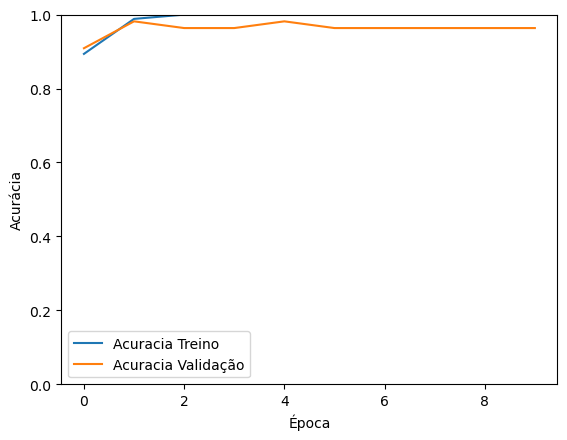

In [42]:
# Mostra o erro de treino e validação a cada época treinada
historico = np.array(historico)

plt.plot(historico[:,2:])
plt.legend(['Acuracia Treino', 'Acuracia Validação'])
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim(0,1)
plt.show()

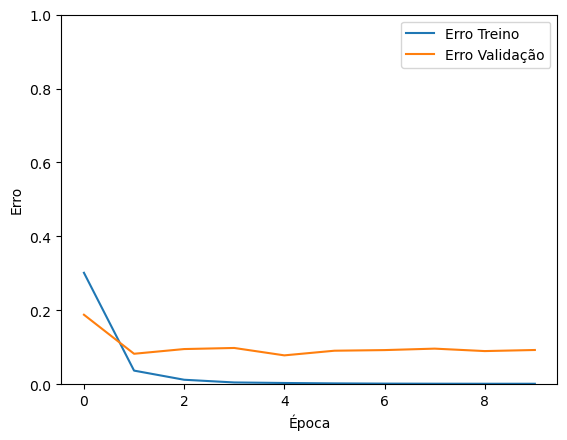

In [41]:
# Mostra o erro de treino e validação a cada época treinada
historico = np.array(historico)

plt.plot(historico[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.show()

#### <a>Função de predição</a>

Vamos criar a função para prever a classe de uma imagem com o melhor modelo treinado. É bem parecido com o que fazemos na validação, um "forward pass" na rede, sem atualizar os gradientes ou os parâmetros da rede.

In [60]:
indice_para_classe

{0: 'batata', 1: 'cenoura', 2: 'limao', 3: 'tomate'}

In [43]:
def predicao_lets_veggie(imagem_teste):
    '''
    Função para realizar a predição do status do AR
    Parâmetros
        :param imagem_teste: imagem já transformada com o PIL
    '''
    transformacao = transformacoes_de_imagens['teste']
    
    tensor_imagem_teste = transformacao(imagem_teste)

    # Teste se possui placa de vídeo Nvidia (ou se instalou a versão certa do PyTorch)
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size).cuda()
    else:
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, image_size, image_size)
    
    dict_predicoes = dict()
    
    # Não precisa calcular os gradientes com o autograd
    with torch.no_grad():
        modelo_treinado.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        predicoes_log = modelo_treinado(tensor_imagem_teste)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        predicoes = torch.exp(predicoes_log)
        
        dict_predicoes = {indice_para_classe[classe]: float(predicoes[0][classe]) for classe in range(numero_de_classes)}
        
        #print(dict_predicoes)
   
    return dict_predicoes

#### <a>Previsão em imagens de teste</a>

Não utilizamos as imagens de teste em nenhum lugar! Assim que aprendemos que deve ser e faremos para todo o sempre como bons e boas cientistas de dados.

Vamos fazer algumas previsões só para "brincar" e depois calculamos a acurácia.

In [63]:
pastas_com_nomes_de_vegetais

['batata', 'cenoura', 'limao', 'tomate']

In [64]:
pasta_teste

'./data/processed/teste'

'batata'

'cenoura'

'limao'

'tomate'

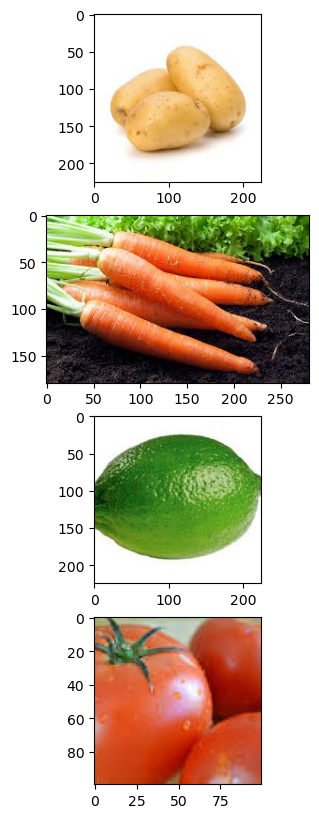

In [49]:
# Testando cada uma das classes
figura, plots = plt.subplots(nrows=numero_de_classes, ncols=1, figsize=(5, 10))

for indice, classe in enumerate(pastas_com_nomes_de_vegetais):
    pasta_teste_classe = os.path.join(pasta_teste, classe)
    imagem = os.path.join(pasta_teste_classe, os.listdir(pasta_teste_classe)[2])
    imagem_teste = PIL.Image.open(imagem)

    plots[indice].imshow(imagem_teste)
    
    predicoes = predicao_lets_veggie(imagem_teste)
   
   
    display(max(predicoes, key=predicoes.get))

In [50]:
# Função que perpassa todas as imagens na pasta de teste
# Realiza a predição utilizando a função predicao_lets_veggie
# e calcula a acurácia (total acertos/total imagens)
def acuracia_teste(pasta_teste):
    acertos = 0
    total_imagens = 0
    
    for classe in os.listdir(pasta_teste):
        pasta_completa = os.path.join(pasta_teste, classe)
        total_imagens += len(os.listdir(pasta_completa))
        
        for imagem in os.listdir(pasta_completa):
            imagem = os.path.join(pasta_completa, imagem)
            imagem_teste = PIL.Image.open(imagem)
            predicoes = predicao_lets_veggie(imagem_teste)
            predicao = max(predicoes, key=predicoes.get)

            if predicao == classe:
                acertos += 1
    
    return 100 * acertos/total_imagens

In [51]:
# Chamando a função e passando a pasta com as imagens de teste
acuracia_teste(pasta_teste)

96.49122807017544

#### <a>Deploy do Modelo</a>

Vamos fazer uma aplicação simples usando o maravilhoso Gradio! 

In [52]:
import gradio as gr

interface_gradio = gr.Interface(fn=predicao_lets_veggie, 
                                inputs=gr.inputs.Image(type="pil"), 
                                outputs="label").launch(share=True)

G:\Anaconda3\lib\site-packages\gradio\inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
G:\Anaconda3\lib\site-packages\gradio\inputs.py:262: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://1ffd0526d3143e10f8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
